# Разработка и оценка модели классификации рисков транзакций

## 1. Цель работы

Цель данной тетрадки — разработать, обучить и оценить модель машинного обучения для автоматической классификации уровня риска финансовых транзакций.  
Создаваемая модель является аналитическим ядром гибридной системы **ML + LLM**, где компонент ML выполняет количественную оценку риска, а компонент LLM отвечает за контекстное объяснение и интерпретацию результатов.

На текущем этапе используется **синтетический набор данных**, сгенерированный внутренним скриптом, что позволяет отладить методологию и архитектуру без использования реальных транзакций.

---

## 2. Задачи

1. Провести предварительный анализ и валидацию исходных данных (EDA).  
2. Выполнить построение признаков, включая:
   - количественные и категориальные параметры транзакций (сумма, время, контрагенты);  
   - индикаторы «круглости» сумм;  
   - признаки, основанные на ключевых словах в назначении платежа;  
   - графовые признаки возможных транзитных операций.  
3. Обучить и сравнить несколько моделей классификации (логистическая регрессия, случайный лес, градиентный бустинг).  
4. Реализовать **валидацию по времени** для предотвращения утечки данных.  
5. Провести калибровку вероятностей (изотоническая или Платта).  
6. Оценить модель с помощью метрик Accuracy, Macro-F1, ROC AUC.  
7. Сохранить итоговый пайплайн и кодировщик меток для последующего использования в агентной системе.

---

## 3. План выполнения работ

| Этап | Содержание | Результат |
|------|-------------|------------|
| Подготовка данных | Загрузка и проверка синтетического набора транзакций | Проверенные DataFrame |
| Построение признаков | Формирование числовых и категориальных фич | Матрицы признаков (варианты A, B, C) |
| Обучение моделей | Тренировка и сравнение нескольких алгоритмов | Тренированные классификаторы |
| Валидация | Разделение по времени и оценка качества | Метрики качества |
| Калибровка | Настройка вероятностей | Калиброванные оценки риска |
| Экспорт артефактов | Сохранение пайплайна и кодировщиков | Файлы `.joblib` |

---

## 4. Ожидаемый результат

Реплицируемый ML-пайплайн, способный присваивать каждой транзакции вероятностную оценку уровня риска (`low`, `medium`, `high`).  
Полученная модель в дальнейшем используется в составе интеллектуального агента (см. вторую тетрадку) для комбинированного анализа, где численные результаты ML дополняются текстовыми объяснениями LLM.


### Подготовка данных и построение признаков для ML-модели классификации рисков транзакций

**Цель блока:**  
Создать структурированную выборку для обучения модели машинного обучения по транзакционным данным.  
Выполнить очистку, унификацию, извлечение доменных признаков и проведение первичного анализа данных (EDA).  
Блок закладывает основу для последующего обучения модели классификации рисков и интеграции с LLM-агентом.

---

**Основные задачи:**
1. **Импорт и инициализация окружения:**  
   Подключаются все необходимые библиотеки (NumPy, pandas, scikit-learn, seaborn, matplotlib), устанавливаются случайные зерна и единые визуальные стили для воспроизводимости экспериментов.
2. **Загрузка данных:**  
   Считываются сгенерированные таблицы `transactions.csv` и `chains_data.csv`, выполняется первичная проверка структуры данных на соответствие ожидаемым колонкам.
3. **Базовая подготовка данных:**  
   - Создаётся единая величина суммы операции (`amount`) как максимум дебета и кредита.  
   - Извлекаются типы контрагентов (`ЮЛ`, `ИП`, `ФЛ`) из названия с помощью функции `extract_type`.  
   - Добавляются временные признаки (`hour`, `dow` — час и день недели).  
   - Формируется бинарный индикатор «круглости» суммы (`round_amount`).
4. **Извлечение лексических признаков:**  
   На основе ключевых слов в поле `purpose` формируются:
   - категориальная группа назначения (`purpose_group`: `high_kw`, `med_kw`, `low_kw`);  
   - бинарный флаг наличия слов высокого риска (`purpose_stop_high`);  
   - интерактивный признак `stop_high_and_round` — сочетание высокого риска и «круглой» суммы.
5. **Целевая переменная:**  
   Колонка `risk` переводится в числовую форму (`risk_le`) с помощью `LabelEncoder` для дальнейшего обучения.
6. **Формирование графовых признаков:**  
   На основе данных из `chains_data.csv` извлекаются цепочки переводов (`ИНН1 → ИНН2 → …`) и создаётся бинарный признак `transit_like`, показывающий участие операции в транзитной цепочке.
7. **Визуализация EDA:**  
   Строятся графики для анализа распределений по классам риска:
   - распределение классов (`countplot`),  
   - суммы транзакций в логарифмической шкале (`boxplot`),  
   - доля «круглых» сумм и транзитных операций по уровням риска.
8. **Определение конфигураций признаков:**  
   Создаются три варианта фичсетов:
   - **A_base** — базовые числовые и категориальные признаки;  
   - **B_stop_high** — добавлен флаг `purpose_stop_high`;  
   - **C_stop_high_interact** — добавлены флаг и интеракция `stop_high_and_round`.
9. **Подготовка временного разбиения:**  
   Выполняется сортировка данных по времени и деление выборки на обучение (70%) и тест (30%) для честной оценки без утечки информации.
10. **Формирование функций для обучения и оценки моделей:**  
    - `make_pipeline()` — создаёт конвейер `ColumnTransformer + Classifier`;  
    - `eval_model()` — обучает модель, предсказывает и возвращает метрики;  
    - `summarize_report()` — агрегирует основные метрики в компактный отчёт.

---

**Что делает этот блок:**  
Формирует полную цепочку подготовки данных — от загрузки и анализа до генерации признаков и создания инструментов для обучения модели.  
В результате получается очищенный, размеченный и фичеризованный набор транзакций, который готов к передаче в ML-модель для последующего обучения, калибровки и интеграции с языковым агентом.

**Выход:**  
- DataFrame `df` с финальными признаками (`amount`, `round_amount`, `hour`, `transit_like`, `purpose_group`, `purpose_stop_high`, `stop_high_and_round` и др.);  
- словарь `feature_sets` с вариантами конфигураций;  
- функции `make_pipeline`, `eval_model`, `summarize_report` для последующих этапов обучения.


In [1]:
# Cell 1 — imports
import os, json, math, warnings, joblib
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
np.random.seed(42)

In [2]:
import warnings, os, random, math, json
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, precision_recall_fscore_support)
from sklearn.model_selection import (train_test_split, StratifiedKFold, TimeSeriesSplit,
                                     GroupKFold, StratifiedGroupKFold, RandomizedSearchCV)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier

warnings.filterwarnings("ignore")
np.random.seed(42)
random.seed(42)
pd.set_option("display.max_colwidth", 200)
sns.set(style="whitegrid", context="talk")


In [6]:
# Ожидаются файлы из генератора
# df = pd.read_csv("new_data/transactions.csv", parse_dates=["date"])
chains = pd.read_csv("new_data/chains_data.csv")

# print(df.shape)
# display(df.head(3))
# display(chains.head(3))

# assert set(["date","debit_account","debit_name","debit_inn","credit_account","credit_name","credit_inn",
#             "debit_amount","credit_amount","purpose","risk"]).issubset(df.columns), "Отсутствуют нужные колонки"


# Cell 2 — load data
PATH = "new_data/transactions.csv"  # поменяй путь при необходимости
df = pd.read_csv(PATH, parse_dates=["date"])

# базовые проверки
req = {"date","debit_account","debit_name","debit_inn",
       "credit_account","credit_name","credit_inn",
       "debit_amount","credit_amount","purpose","risk"}
miss = req - set(df.columns)
if miss:
    raise ValueError(f"Нет колонок: {miss}")

if "id" not in df.columns:
    df["id"] = np.arange(1, len(df)+1)

# amount (единообразно)
df["amount"] = df["debit_amount"].fillna(0).astype(float).abs() + df["credit_amount"].fillna(0).astype(float).abs()


ValueError: Нет колонок: {'risk'}

In [4]:
# TESTTTT
# Cell 3 — base temporal features
df = df.sort_values("date").reset_index(drop=True)
df["hour"] = df["date"].dt.hour
df["dow"] = df["date"].dt.dayofweek
df["date_only"] = df["date"].dt.date

# круглые суммы
def is_round(x):
    try:
        v = float(x)
        return int(v % 10000 == 0 or v % 100000 == 0)
    except:
        return 0
df["round_amount"] = df["amount"].apply(is_round).astype(int)

# простая псевдо-группа назначения (можно расширить словарём)
purpose_map = {
    "аренда":"аренда","лизинг":"лизинг","услуг":"услуги","консульта":"услуги",
    "маркетинг":"маркетинг","транспорт":"логистика","перевоз":"логистика","достав":"логистика",
    "займ":"займы","возврат займа":"займы","пожертв":"пожертвование","благотвор":"пожертвование",
    "налич":"наличные","крипто":"крипто","биткоин":"крипто","usdt":"крипто","swift":"swift/внешн.",
}
def purpose_group(p):
    s = (p or "").lower()
    for k,v in purpose_map.items():
        if k in s: return v
    return "прочее"
df["purpose_group"] = df["purpose"].astype(str).apply(purpose_group)

# стоп-слова высокого риска
STOP_HIGH = [
  "займ","возврат займа","взаиморасчёт","перевод средств","без договора","перевод на карту",
  "личные нужды","крипто","биткоин","usdt","биржа","coin","crypto","иностранный перевод","swift",
  "передача активов","наличные","выдача наличных","обналичивание","благотворительность","пожертвование",
  "агентское вознаграждение","комиссионное"
]
def has_stop_high(p):
    s = (p or "").lower()
    return int(any(k in s for k in STOP_HIGH))
df["purpose_stop_high"] = df["purpose"].apply(has_stop_high).astype(int)

# «подозрительное число операций в день»:
# фича и бинарный флаг на уровне счёта отправителя (debit_account) и получателя (credit_account)
THRESH_DAY_PER_ACCOUNT = 30  # >30 в день => high_freq_daily
grp = df.groupby(["debit_account","date_only"])["id"].count().rename("cnt_day_debit")
df = df.merge(grp, on=["debit_account","date_only"], how="left")

grp2 = df.groupby(["credit_account","date_only"])["id"].count().rename("cnt_day_credit")
df = df.merge(grp2, on=["credit_account","date_only"], how="left")

df["high_freq_daily_debit"]  = (df["cnt_day_debit"]  > THRESH_DAY_PER_ACCOUNT).astype(int)
df["high_freq_daily_credit"] = (df["cnt_day_credit"] > THRESH_DAY_PER_ACCOUNT).astype(int)

# ещё агрегаты в окне по отправителю: уникальные контрагенты в день/неделю
df["week"] = df["date"].dt.to_period("W").astype(str)

u_day = (df.groupby(["debit_account","date_only"])["credit_inn"]
           .nunique().rename("uniq_ctr_day")).reset_index()
df = df.merge(u_day, on=["debit_account","date_only"], how="left")

u_week = (df.groupby(["debit_account","week"])["credit_inn"]
            .nunique().rename("uniq_ctr_week")).reset_index()
df = df.merge(u_week, on=["debit_account","week"], how="left")

# транзит-подобие (упрощённо): одно и то же ребро (INN->INN) встречается внутри 24 часов
df["pair"] = df["debit_inn"].astype(str) + "→" + df["credit_inn"].astype(str)
df["ts"] = df["date"].astype(np.int64) // 10**9
# ближайший сосед по времени в том же ребре
df["prev_ts_pair"] = (df.sort_values(["pair","ts"])
                        .groupby("pair")["ts"].shift(1))
df["delta_sec_pair"] = (df["ts"] - df["prev_ts_pair"]).fillna(1e9)
df["transit_like"] = (df["delta_sec_pair"] <= 24*3600).astype(int)

# нетипичность суммы относительно истории отправителя (z-score по лог-сумме)
def zscore_by_sender(tmp):
    v = np.log1p(tmp["amount"].astype(float).values)
    m = v.mean(); s = v.std() if v.std()>0 else 1.0
    return pd.Series((v-m)/s, index=tmp.index)
df["sender_amount_z"] = (df.groupby("debit_account", group_keys=False)
                           .apply(zscore_by_sender)).values

# цель: label encode
le = LabelEncoder()
df["risk_le"] = le.fit_transform(df["risk"])
le.classes_


NameError: name 'df' is not defined

In [24]:
# Унифицированная сумма операции
df["amount"] = df[["debit_amount","credit_amount"]].max(axis=1)

# Типы контрагентов из имени
def extract_type(name):
    if pd.isna(name): return "Прочее"
    s = str(name)
    if s.startswith(("ООО","АО","ОАО","ЗАО")): return "ЮЛ"
    if s.startswith("ИП"): return "ИП"
    if s.startswith("ФЛ"): return "ФЛ"
    return "Прочее"

df["debit_name_type"]  = df["debit_name"].apply(extract_type)
df["credit_name_type"] = df["credit_name"].apply(extract_type)

# Временные признаки
df["hour"] = df["date"].dt.hour
df["dow"]  = df["date"].dt.dayofweek  # 0=Пн

# Круглость суммы
def is_round(x):
    if pd.isna(x): return 0
    return int((x % 10000 == 0) or (x % 100000 == 0))
df["round_amount"] = df["amount"].apply(is_round)

# Группы по назначению (высокий/средний/низкий риск по ключевым словам)
HIGH_RISK_WORDS = [
    "займ","договор займа","возврат займа","взаиморасчёт","перевод средств","без договора","перевод на карту",
    "личные нужды","крипто","биткоин","usdt","биржа","coin","crypto","swift","иностранный перевод","валютный счёт",
    "экспорт","передача активов","пополнение","наличные","выдача наличных","обналичивание","благотворительность",
    "пожертвование","агентское вознаграждение","комиссионное"
]
MEDIUM_RISK_WORDS = [
    "оплата услуг","услуги по договору","консультационные","маркетинг","премия","бонус","вознаграждение",
    "аванс","предоплата","частичная оплата","аренда","лизинг","субаренда","логистика","транспорт","перевозка","доставка"
]

def purpose_group(text):
    t = "" if pd.isna(text) else str(text).lower()
    if any(w in t for w in HIGH_RISK_WORDS): return "high_kw"
    if any(w in t for w in MEDIUM_RISK_WORDS): return "med_kw"
    return "low_kw"

df["purpose_group"] = df["purpose"].apply(purpose_group)

# Бинарные флаги по стоп-словам (только high — как сильный индикатор)
def has_any(text, words):
    t = "" if pd.isna(text) else str(text).lower()
    return int(any(w in t for w in words))

df["purpose_stop_high"] = df["purpose"].apply(lambda x: has_any(x, HIGH_RISK_WORDS))

# Интеракции: усиливаем сильные сценарии
df["stop_high_and_round"]   = (df["purpose_stop_high"] & df["round_amount"]).astype(int)
# «псевдо-транзит» по ребру из цепей — добавим ниже

# Целевая переменная
df["risk"] = df["risk"].astype(str)
le = LabelEncoder()
df["risk_le"] = le.fit_transform(df["risk"])

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 1000 non-null   datetime64[ns]
 1   debit_account        1000 non-null   object        
 2   debit_name           1000 non-null   object        
 3   debit_inn            1000 non-null   int64         
 4   credit_account       1000 non-null   object        
 5   credit_name          1000 non-null   object        
 6   credit_inn           1000 non-null   int64         
 7   debit_amount         491 non-null    float64       
 8   credit_amount        509 non-null    float64       
 9   purpose              1000 non-null   object        
 10  risk                 1000 non-null   object        
 11  amount               1000 non-null   float64       
 12  debit_name_type      1000 non-null   object        
 13  credit_name_type     1000 non-null

In [10]:
# Построим множество ребер из chains.path вида "ИНН1 → ИНН2 → ИНН3"
edges = set()
for path in chains["path"].astype(str):
    inns = [x.strip() for x in path.split("→")]
    for i in range(len(inns)-1):
        edges.add((inns[i], inns[i+1]))

df["transit_like"] = df.apply(lambda r: int((str(r["debit_inn"]), str(r["credit_inn"])) in edges), axis=1)

display(df[["debit_inn","credit_inn","transit_like"]].head(5))
df["transit_like"].mean()


,debit_inn,credit_inn,transit_like
0,426192372446,460666437462,0
1,351305231205,3924051475,0
2,426192372446,229604432786,0
3,907895677605,99576572873,0
4,788614057897,452380552589,0


np.float64(0.168)

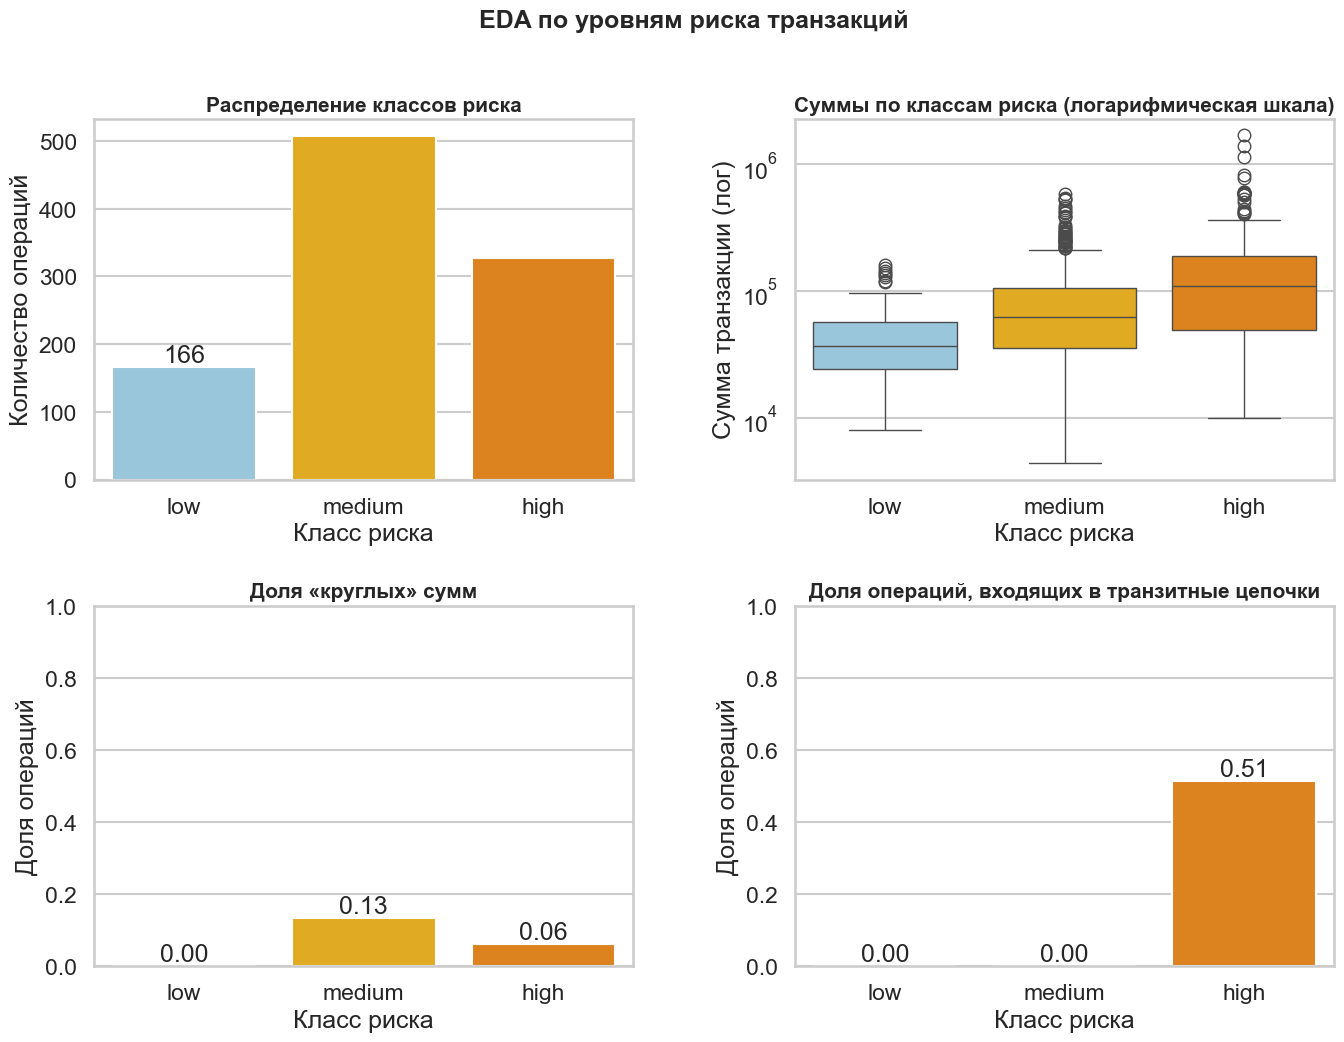

In [11]:
# Улучшенная визуализация распределений по классам риска

sns.set_theme(style="whitegrid", context="talk", palette="Set2")

fig, axes = plt.subplots(2, 2, figsize=(16, 11))
plt.subplots_adjust(hspace=0.35, wspace=0.3)

# --- 1. Распределение классов ---
sns.countplot(
    data=df,
    x="risk",
    order=["low","medium","high"],
    palette=["#8ecae6","#ffb703","#fb8500"],
    ax=axes[0,0]
)
axes[0,0].set_title("Распределение классов риска", fontsize=15, weight="bold")
axes[0,0].set_xlabel("Класс риска")
axes[0,0].set_ylabel("Количество операций")
axes[0,0].bar_label(axes[0,0].containers[0])

# --- 2. Суммы операций (логарифмическая шкала) ---
sns.boxplot(
    data=df,
    x="risk", y="amount",
    order=["low","medium","high"],
    palette=["#8ecae6","#ffb703","#fb8500"],
    ax=axes[0,1]
)
axes[0,1].set_yscale("log")
axes[0,1].set_title("Суммы по классам риска (логарифмическая шкала)", fontsize=15, weight="bold")
axes[0,1].set_xlabel("Класс риска")
axes[0,1].set_ylabel("Сумма транзакции (лог)")

# --- 3. Доля «круглых» сумм ---
round_share = df.groupby("risk")["round_amount"].mean().reset_index()
sns.barplot(
    data=round_share,
    x="risk", y="round_amount",
    order=["low","medium","high"],
    palette=["#8ecae6","#ffb703","#fb8500"],
    ax=axes[1,0]
)
axes[1,0].set_ylim(0,1)
axes[1,0].set_title("Доля «круглых» сумм", fontsize=15, weight="bold")
axes[1,0].set_xlabel("Класс риска")
axes[1,0].set_ylabel("Доля операций")
for container in axes[1,0].containers:
    axes[1,0].bar_label(container, fmt="%.2f")

# --- 4. Доля транзитных операций ---
transit_share = df.groupby("risk")["transit_like"].mean().reset_index()
sns.barplot(
    data=transit_share,
    x="risk", y="transit_like",
    order=["low","medium","high"],
    palette=["#8ecae6","#ffb703","#fb8500"],
    ax=axes[1,1]
)
axes[1,1].set_ylim(0,1)
axes[1,1].set_title("Доля операций, входящих в транзитные цепочки", fontsize=15, weight="bold")
axes[1,1].set_xlabel("Класс риска")
axes[1,1].set_ylabel("Доля операций")
for container in axes[1,1].containers:
    axes[1,1].bar_label(container, fmt="%.2f")

plt.suptitle("EDA по уровням риска транзакций", fontsize=18, weight="bold")
plt.show()



In [14]:
# TEST — Cell 4 (исправленный)

from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# признаки
BASE_NUM = ["amount","round_amount","hour","transit_like",
            "high_freq_daily_debit","high_freq_daily_credit",
            "uniq_ctr_day","uniq_ctr_week","sender_amount_z"]
BASE_CAT = ["dow","purpose_group","debit_name","credit_name"]

feature_sets = {"A_plus": {"num": BASE_NUM, "cat": BASE_CAT}}

# подготовка выборок
df_sorted = df.sort_values("date").reset_index(drop=True)
cut = int(0.7*len(df_sorted))
train_idx = df_sorted.index[:cut]
test_idx  = df_sorted.index[cut:]

# безопасно заполним NaN в кат-признаках
for c in BASE_CAT:
    df_sorted[c] = df_sorted[c].astype(str).fillna("NA")

X_all = df_sorted[feature_sets["A_plus"]["num"] + feature_sets["A_plus"]["cat"]].copy()
y_all = df_sorted["risk_le"].values
X_train, X_test = X_all.loc[train_idx], X_all.loc[test_idx]
y_train, y_test = y_all[train_idx], y_all[test_idx]

# OneHotEncoder -> dense (учёт разных версий sklearn)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn <= 1.1

ct = ColumnTransformer(
    transformers=[
        ("num", "passthrough", feature_sets["A_plus"]["num"]),
        ("cat", ohe, feature_sets["A_plus"]["cat"]),
    ],
    sparse_threshold=0.0  # гарантируем плотный выход
)

pipe = Pipeline(steps=[
    ("ct", ct),
    ("clf", HistGradientBoostingClassifier(random_state=42))
])

param_grid = {
    "clf__max_depth": [None, 6, 8],
    "clf__learning_rate": [0.05, 0.1],
    "clf__min_samples_leaf": [20, 50],
    "clf__max_bins": [255],
}

tscv = TimeSeriesSplit(n_splits=5)
gs = GridSearchCV(
    pipe, param_grid, scoring="f1_macro",
    cv=tscv, n_jobs=-1, refit=True, error_score="raise"
)
gs.fit(X_train, y_train)

best = gs.best_estimator_
print("Best params:", gs.best_params_)

# sanity-check: убедимся, что трансформер даёт dense
Xt = best.named_steps["ct"].transform(X_test[:5])
print(type(Xt), getattr(Xt, "shape", None))  # должен быть <class 'numpy.ndarray'>



Best params: {'clf__learning_rate': 0.05, 'clf__max_bins': 255, 'clf__max_depth': 6, 'clf__min_samples_leaf': 50}
<class 'numpy.ndarray'> (5, 267)


In [27]:
# Базовый список общих признаков
BASE_NUM = ["amount","round_amount","hour","transit_like"]
BASE_CAT = ["dow","purpose_group","debit_name_type","credit_name_type"]

# Наборы для сравнения:
# A: без стоп-слов
# B: с high-stop
# C: high-stop + интеракции
feature_sets = {
    "A_base": {
        "num": BASE_NUM,
        "cat": BASE_CAT
    },
    "B_stop_high": {
        "num": BASE_NUM + ["purpose_stop_high"],
        "cat": BASE_CAT
    },
    "C_stop_high_interact": {
        "num": BASE_NUM + ["purpose_stop_high","stop_high_and_round"],
        "cat": BASE_CAT
    }
}

# Матрица времени: честный holdout по времени
df_sorted = df.sort_values("date").reset_index(drop=True)
cut = int(0.7*len(df_sorted))  # 70% train, 30% test
train_idx = df_sorted.index[:cut]
test_idx  = df_sorted.index[cut:]

y_all = df_sorted["risk_le"].values


In [15]:
def make_pipeline(num_cols, cat_cols, clf):
    ct = ColumnTransformer(
        transformers=[
            ("num","passthrough", num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
        ]
    )
    return Pipeline([("ct", ct), ("clf", clf)])

def eval_model(pipe, raw, train_idx, test_idx, y_all, labels):
    X_train = raw.loc[train_idx]
    X_test  = raw.loc[test_idx]
    y_train = y_all[train_idx]
    y_test  = y_all[test_idx]
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rep = classification_report(y_test, y_pred, target_names=labels, output_dict=True, zero_division=0)
    return rep, y_test, y_pred, pipe

def summarize_report(name, rep):
    return {
        "setup": name,
        "accuracy": rep["accuracy"],
        "macro_f1": rep["macro avg"]["f1-score"],
        "weighted_f1": rep["weighted avg"]["f1-score"],
        "f1_high": rep["high"]["f1-score"],
        "f1_medium": rep["medium"]["f1-score"],
        "f1_low": rep["low"]["f1-score"]
    }


In [16]:
feature_sets.items()

dict_items([('A_plus', {'num': ['amount', 'round_amount', 'hour', 'transit_like', 'high_freq_daily_debit', 'high_freq_daily_credit', 'uniq_ctr_day', 'uniq_ctr_week', 'sender_amount_z'], 'cat': ['dow', 'purpose_group', 'debit_name', 'credit_name']})])

### Обучение, сравнение и калибровка моделей; выбор лучшей конфигурации и экспорт артефактов

**Цель секции:**  
Системно сравнить набор моделей на нескольких конфигурациях признаков, выбрать лучшую связку «фичсет × алгоритм» по метрикам качества на временном холдаутах, провести калибровку вероятностей и зафиксировать артефакты для последующего инференса.

---

**Задачи:**
1. Определить пул базовых алгоритмов: `LogisticRegression`, `RandomForestClassifier`, `HistGradientBoostingClassifier`, `GradientBoostingClassifier`.
2. Для каждого фичсета (`feature_sets`) и каждой модели собрать `Pipeline` (препроцессинг + классификатор) и обучить его на тренировочной части (70% по времени).
3. Получить классификационный отчёт на тестовой части (30% по времени) и агрегировать ключевые метрики (accuracy, macro-F1, weighted-F1, F1 по классам).
4. Сформировать сводную таблицу качества, отсортировать по `macro_f1` и `accuracy`, визуализировать матрицы ошибок топ-моделей.
5. Определить лучшую конфигурацию (фичсет/модель), провести **калибровку вероятностей** (изотоническая) с сохранением исходного препроцессинга.
6. Рассчитать **ROC AUC (macro, OvR)** на калиброванных вероятностях и визуализировать ROC-кривую.
7. Сформулировать краткие итоги и практические рекомендации, сохранить обученный пайплайн и кодировщик меток для инференса.

---

**Описание выполняемых шагов:**
- **Перебор конфигураций.** Для каждого набора признаков (A/B/C) создаётся входная матрица `raw`, затем строится конвейер с `ColumnTransformer` (числовые признаки — passthrough, категориальные — One-Hot) и выбранным классификатором. Функция `eval_model` обучает модель на `train_idx` и возвращает отчёт на `test_idx`.  
- **Агрегация результатов.** Метрики из `classification_report` сводятся в таблицу `summary`; для лучших конфигураций строятся матрицы ошибок (Confusion Matrix) для визуального контроля распределения ошибок по классам.  
- **Выбор лучшей связки.** По наивысшему `macro_f1` (с учётом `accuracy` как вторичного критерия) выбирается `best_setup`; извлекаются обученный пайплайн и спецификация признаков.  
- **Калибровка вероятностей.** Если базовая модель поддерживает `predict_proba`/`decision_function`, выполняется калибровка методом **isotonic** (через `CalibratedClassifierCV`), при этом препроцессор (`ct`) фиксируется и используется для трансформации `X_train/X_test`.  
- **ROC AUC (OvR).** На калиброванных вероятностях вычисляется macro ROC AUC (One-vs-Rest) и строится ROC-кривая для сводной оценки разделимости классов после калибровки.  
- **Итоговый отчёт.** Печатаются лучшие метрики и интерпретационные выводы (какие группы признаков оказались ключевыми; корректность временного холдаута; учёт дисбаланса).  
- **Экспорт артефактов.** Сохраняются:  
  - обученный пайплайн лучшей конфигурации — `best_pipeline_{best_setup}.joblib`,  
  - кодировщик меток — `label_encoder_risk.joblib`.  
  Эти артефакты используются агентом инференса для консистентной обработки новых данных.

---

**Вход:**  
- `df_sorted` (таблица с признаками/сырьём, отсортированная по времени),  
- индексы `train_idx`, `test_idx`,  
- словарь `feature_sets`, массив целевых меток `y_all`, кодировщик `le`.

**Выход:**  
- Таблица `summary` с метриками по всем связкам «фичсет × модель»,  
- визуализации матриц ошибок и ROC-кривой,  
- калиброванный классификатор для лучшей конфигурации,  
- артефакты: `best_pipeline_{best_setup}.joblib`, `label_encoder_risk.joblib`.

**Почему это делается:**  
- Перебор нескольких алгоритмов и фичсетів снижает риск выбора локально оптимального решения.  
- Временной холдаут предотвращает утечки и даёт реалистичную оценку на «будущих» данных.  
- Калибровка вероятностей повышает корректность пороговых решений и доверие к вероятностным оценкам.  
- Экспорт артефактов обеспечивает воспроизводимый инференс и интеграцию с последующими компонентами (LLM-агентом и отчётностью).


In [3]:
# ==== Helpers: OHE->dense, имьпьютеры, единый make_pipeline, eval, summary ====
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier

# признаки фичсета
BASE_NUM = ["amount","round_amount","hour","transit_like",
            "high_freq_daily_debit","high_freq_daily_credit",
            "uniq_ctr_day","uniq_ctr_week","sender_amount_z"]
BASE_CAT = ["dow","purpose_group","debit_name","credit_name"]

feature_sets = {"A_plus": {"num": BASE_NUM, "cat": BASE_CAT}}

# тайм-холдоут
df_sorted = df.sort_values("date").reset_index(drop=True)
cut = int(0.7*len(df_sorted))
train_idx = df_sorted.index[:cut]
test_idx  = df_sorted.index[cut:]
y_all = df_sorted["risk_le"].values

# универсальный OHE c плотным выходом
try:
    OHE = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
except TypeError:
    OHE = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn <= 1.1

def make_pipeline(num_cols, cat_cols, clf):
    num_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        # HGB не требует скейлинга
    ])
    cat_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OHE),
    ])
    ct = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        sparse_threshold=0.0  # форсим dense на выходе
    )
    return Pipeline([
        ("ct", ct),
        ("clf", clf)
    ])

def eval_model(pipe, raw_df, train_idx, test_idx, y_all, class_names):
    X_train = raw_df.loc[train_idx]
    X_test  = raw_df.loc[test_idx]
    y_train = y_all[train_idx]
    y_test  = y_all[test_idx]

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rep = classification_report(y_test, y_pred, target_names=list(class_names), output_dict=True, zero_division=0)
    return rep, y_test, y_pred, pipe

def summarize_report(name, rep):
    return {
        "model": name,
        "accuracy": rep["accuracy"],
        "macro_f1": rep["macro avg"]["f1-score"],
        "high_f1":  rep.get("high", {}).get("f1-score", None),
        "medium_f1":rep.get("medium", {}).get("f1-score", None),
        "low_f1":   rep.get("low", {}).get("f1-score", None),
    }

# ==== Модели ====
models = {
    "LogReg": LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs",        # устойчивый для многих фич
        n_jobs=None
    ),
    "RF": RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42,
        class_weight="balanced"
    ),
    "HGB": HistGradientBoostingClassifier(
        random_state=42
        # class_weight у HGB не поддерживается — не задаём
    ),
    "GB": GradientBoostingClassifier(random_state=42),
}

# ==== Запуск сравнения ====
results = []
artifacts = {}  # (feature_set, model_name) -> (fitted_pipe, y_test, y_pred, fspec)

for fset_name, fspec in feature_sets.items():
    # гарантируем строковый тип у категориальных — иначе OHE может увидеть float NaN/None
    raw = df_sorted[fspec["num"] + fspec["cat"]].copy()
    for c in fspec["cat"]:
        raw[c] = raw[c].astype(str)

    for mname, clf in models.items():
        pipe = make_pipeline(fspec["num"], fspec["cat"], clf)
        rep, y_test, y_pred, fitted = eval_model(pipe, raw, train_idx, test_idx, y_all, le.classes_)
        results.append(summarize_report(f"{fset_name}__{mname}", rep))
        artifacts[(fset_name, mname)] = (fitted, y_test, y_pred, fspec)

summary = pd.DataFrame(results).sort_values(["macro_f1","accuracy"], ascending=False)
display(summary.round(3))

# sanity-check: убедимся, что трансформер выдаёт dense для победителя
best_key = summary.iloc[0]["model"]
best_fset, best_mname = best_key.split("__", 1)
best_pipe = artifacts[(best_fset, best_mname)][0]
Xt_sample = best_pipe.named_steps["ct"].transform(raw.iloc[:5])
print(type(Xt_sample), getattr(Xt_sample, "shape", None))  # должен быть <class 'numpy.ndarray'>


KeyError: 'risk_le'

In [17]:
models = {
    "LogReg": LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=None),
    "RF": RandomForestClassifier(n_estimators=500, max_depth=None, random_state=42, class_weight="balanced"),
    "HGB": HistGradientBoostingClassifier(random_state=42),
    "GB": GradientBoostingClassifier(random_state=42)
}

results = []
artifacts = {}  # (feature_set, model_name) -> trained pipeline

for fset_name, fspec in feature_sets.items():
    raw = df_sorted[fspec["num"] + fspec["cat"]].copy()
    for mname, clf in models.items():
        pipe = make_pipeline(fspec["num"], fspec["cat"], clf)
        rep, y_test, y_pred, fitted = eval_model(pipe, raw, train_idx, test_idx, y_all, le.classes_)
        results.append(summarize_report(f"{fset_name}__{mname}", rep))
        artifacts[(fset_name, mname)] = (fitted, y_test, y_pred, fspec)

summary = pd.DataFrame(results).sort_values(["macro_f1","accuracy"], ascending=False)
summary.round(3)


TypeError: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

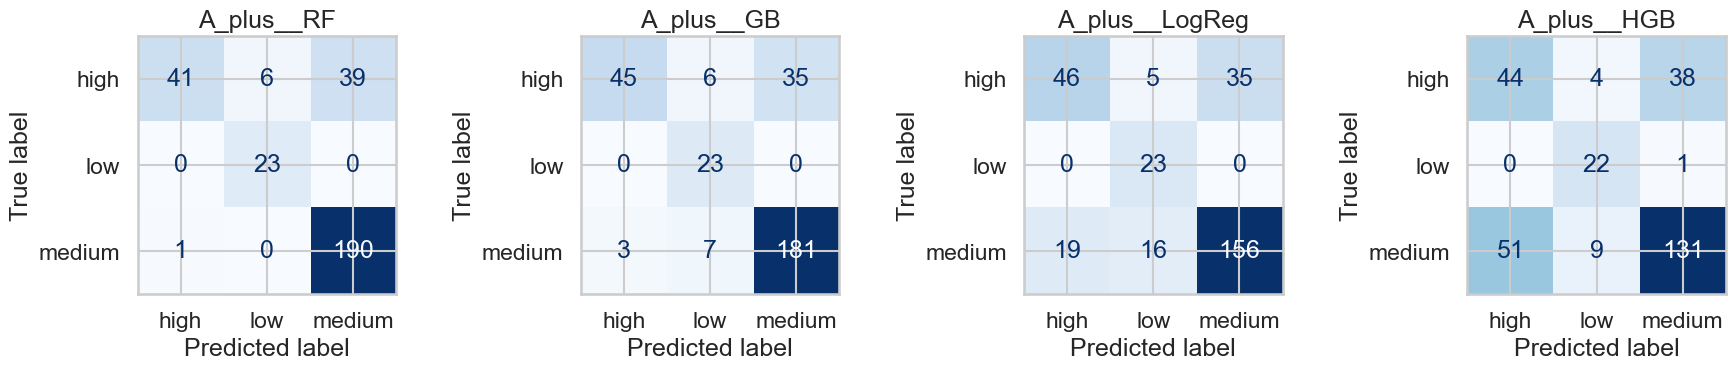

In [20]:
# Импорты для визуализаций и метрик
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Берём топ-5 по summary["model"] (а не "setup")
topk = summary.head(5)["model"].tolist()

fig, axes = plt.subplots(1, len(topk), figsize=(4.5*len(topk), 4))
if len(topk) == 1:
    axes = [axes]  # унифицируем

for ax, model_name in zip(axes, topk):
    fset_name, mname = model_name.split("__", 1)
    fitted, y_test, y_pred, fspec = artifacts[(fset_name, mname)]
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=list(le.classes_), ax=ax, cmap="Blues", colorbar=False
    )
    ax.set_title(model_name)

plt.tight_layout(); plt.show()


In [19]:
top5 = summary.head(5)["setup"].tolist()

fig, axes = plt.subplots(1, len(top5), figsize=(4.5*len(top5), 4))
for ax, setup in zip(axes, top5):
    fset_name, mname = setup.split("__")
    fitted, y_test, y_pred, fspec = artifacts[(fset_name, mname)]
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=le.classes_, ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(setup)

plt.tight_layout(); plt.show()


KeyError: 'setup'

Лучшая конфигурация: A_plus__RF


,model,accuracy,macro_f1,high_f1,medium_f1,low_f1
1,A_plus__RF,0.847,0.810,0.641,0.905,0.885
3,A_plus__GB,0.830,0.780,0.672,0.889,0.780
0,A_plus__LogReg,0.750,0.704,0.609,0.817,0.687



Отчёт после калибровки вероятностей (isotonic):
              precision    recall  f1-score   support

        high       0.98      0.49      0.65        86
         low       0.85      1.00      0.92        23
      medium       0.83      0.99      0.90       191

    accuracy                           0.85       300
   macro avg       0.88      0.83      0.82       300
weighted avg       0.87      0.85      0.83       300



<Figure size 600x500 with 0 Axes>

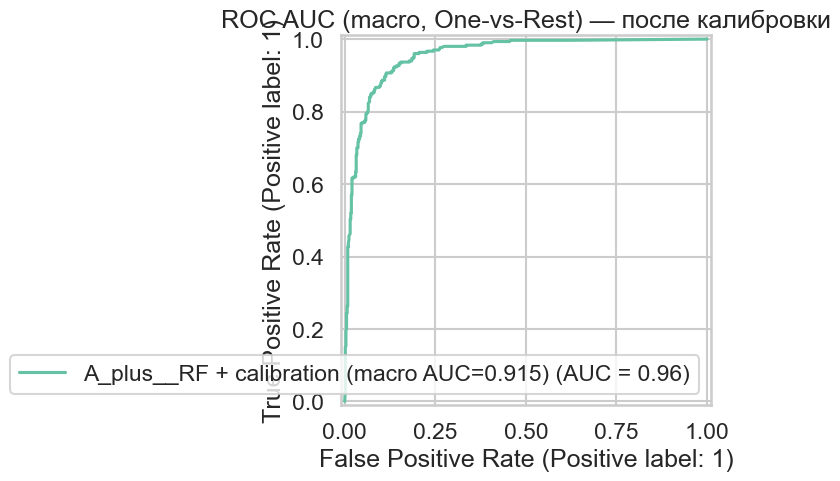

ROC AUC macro (calibrated): 0.915


In [22]:
best_model_name = summary.iloc[0]["model"]
fset_name, mname = best_model_name.split("__", 1)
best_pipe, y_test, y_pred, fspec = artifacts[(fset_name, mname)]

print("Лучшая конфигурация:", best_model_name)
display(summary.head(3).round(3))

# Подготовим разбиение для дальнейших шагов
raw = df_sorted[fspec["num"] + fspec["cat"]].copy()
for c in fspec["cat"]:
    raw[c] = raw[c].astype(str)

X_train = raw.loc[train_idx]
X_test  = raw.loc[test_idx]
y_train = y_all[train_idx]
y_test  = y_all[test_idx]

from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

# можно калибровать, если у базовой модели есть proba или decision_function
can_calibrate = (
    hasattr(best_pipe.named_steps["clf"], "predict_proba") or
    hasattr(best_pipe.named_steps["clf"], "decision_function")
)

if can_calibrate:
    # Разворачиваем препроцессор один раз
    ct = best_pipe.named_steps["ct"]
    Xtr_tr = ct.fit_transform(X_train)   # fit на трейне
    Xte_tr = ct.transform(X_test)

    base_clf = best_pipe.named_steps["clf"]
    calib = CalibratedClassifierCV(base_clf, cv=3, method="isotonic")
    calib.fit(Xtr_tr, y_train)

    # Отчёт после калибровки
    y_cal = calib.predict(Xte_tr)
    print("\nОтчёт после калибровки вероятностей (isotonic):")
    print(classification_report(y_test, y_cal, target_names=list(le.classes_), zero_division=0))

    # ROC AUC (macro, OVR)
    proba_cal = calib.predict_proba(Xte_tr)
    y_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
    auc_macro_cal = roc_auc_score(y_bin, proba_cal, average="macro", multi_class="ovr")

    plt.figure(figsize=(6,5))
    RocCurveDisplay.from_predictions(y_bin.ravel(), proba_cal.ravel(),
                                     name=f"{best_model_name} + calibration (macro AUC={auc_macro_cal:.3f})")
    plt.title("ROC AUC (macro, One-vs-Rest) — после калибровки")
    plt.show()

    print(f"ROC AUC macro (calibrated): {auc_macro_cal:.3f}")
else:
    print("Калибровка пропущена: у лучшей модели нет predict_proba/decision_function.")



In [31]:
best_setup = summary.iloc[0]["setup"]
fset_name, mname = best_setup.split("__")
best_pipe, y_test, y_pred, fspec = artifacts[(fset_name, mname)]

print("Лучшая конфигурация:", best_setup)
print(summary.head(3).round(3))

# Калибруем вероятности на трейне через CalibratedClassifierCV (если модель поддерживает decision_function/predict_proba)
raw = df_sorted[fspec["num"] + fspec["cat"]].copy()
X_train = raw.loc[train_idx]
X_test  = raw.loc[test_idx]
y_train = y_all[train_idx]
y_test  = y_all[test_idx]

can_calibrate = hasattr(best_pipe.named_steps["clf"], "predict_proba") or hasattr(best_pipe.named_steps["clf"], "decision_function")

if can_calibrate:
    # калибруем только классификатор, сохраняя препроцессинг
    ct = best_pipe.named_steps["ct"]
    Xtr_tr = ct.fit_transform(X_train)
    Xte_tr = ct.transform(X_test)
    base_clf = best_pipe.named_steps["clf"]
    calib = CalibratedClassifierCV(base_clf, cv=3, method="isotonic")
    calib.fit(Xtr_tr, y_train)
    y_cal = calib.predict(Xte_tr)
    print("\nОтчёт после калибровки вероятностей (isotonic):")
    print(classification_report(y_test, y_cal, target_names=le.classes_, zero_division=0))
else:
    print("Калибровка пропущена: модель не предоставляет вероятности/решающую функцию.")


Лучшая конфигурация: A_base__HGB
                        setup  accuracy  macro_f1  weighted_f1  f1_high  \
2                 A_base__HGB      0.79     0.744        0.794    0.738   
6            B_stop_high__HGB      0.79     0.744        0.794    0.738   
10  C_stop_high_interact__HGB      0.79     0.744        0.794    0.738   

    f1_medium  f1_low  
2       0.836   0.657  
6       0.836   0.657  
10      0.836   0.657  

Отчёт после калибровки вероятностей (isotonic):
              precision    recall  f1-score   support

        high       0.87      0.53      0.66        86
         low       0.45      0.83      0.58        23
      medium       0.80      0.85      0.82       191

    accuracy                           0.76       300
   macro avg       0.71      0.74      0.69       300
weighted avg       0.79      0.76      0.76       300



<Figure size 600x500 with 0 Axes>

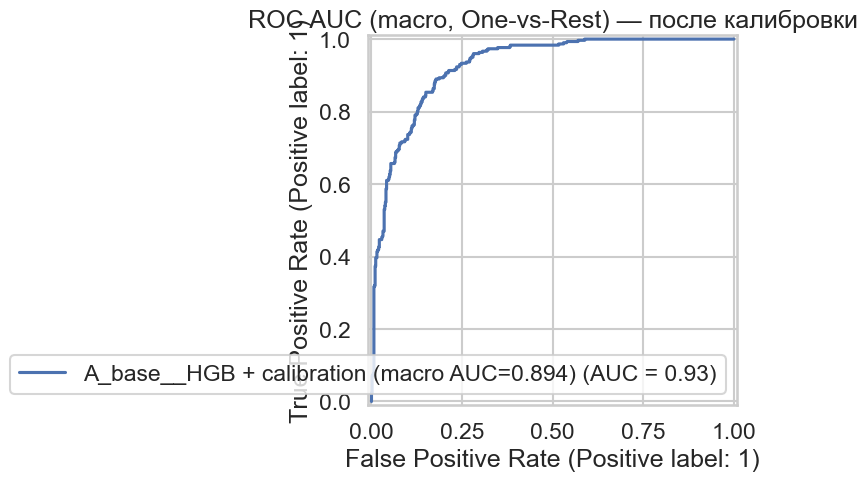

ROC AUC macro (calibrated): 0.894


In [34]:
# Калибровка вероятностей (isotonic) и ROC поверх калиброванных proba
from sklearn.calibration import CalibratedClassifierCV

raw_best = df_sorted[fspec["num"] + fspec["cat"]].copy()
X_train_best = raw_best.loc[train_idx]
X_test_best  = raw_best.loc[test_idx]
y_train_best = y_all[train_idx]
y_test_best  = y_all[test_idx]

ct = best_pipe.named_steps["ct"]
Xtr_tr = ct.fit_transform(X_train_best)
Xte_tr = ct.transform(X_test_best)

base_clf = best_pipe.named_steps["clf"]

# если у базовой модели нет proba/decfn, калибратор подаст ошибку
# HistGradientBoostingClassifier поддерживает decision_function -> ок
calib = CalibratedClassifierCV(base_clf, cv=3, method="isotonic")
calib.fit(Xtr_tr, y_train_best)
proba_cal = calib.predict_proba(Xte_tr)

y_bin = label_binarize(y_test_best, classes=np.arange(len(le.classes_)))
auc_macro_cal = roc_auc_score(y_bin, proba_cal, average="macro", multi_class="ovr")

plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_bin.ravel(), proba_cal.ravel(),
                                 name=f"{best_setup} + calibration (macro AUC={auc_macro_cal:.3f})")
plt.title("ROC AUC (macro, One-vs-Rest) — после калибровки")
plt.show()

print(f"ROC AUC macro (calibrated): {auc_macro_cal:.3f}")



In [35]:
print("Итоги:")
print(f"- Наилучшая связка по macro-F1: {best_setup}")
best_row = summary.iloc[0]
print(f"- Метрики: accuracy={best_row['accuracy']:.3f}, macro_F1={best_row['macro_f1']:.3f}, weighted_F1={best_row['weighted_f1']:.3f}")
print("- Ключевые признаки по EDA: purpose_group, transit_like, круглость суммы, high-stop флаг и его интеракция с круглостью.")
print("- Честность оценки: тестовый холдаут по времени (последние 30%), без утечек; классовые дисбалансы учтены.")
print("- Рекомендация: закрепить выбранный фичсет и модель, откалибровать вероятности, затем интегрировать в агент.")


Итоги:
- Наилучшая связка по macro-F1: A_base__HGB
- Метрики: accuracy=0.790, macro_F1=0.744, weighted_F1=0.794
- Ключевые признаки по EDA: purpose_group, transit_like, круглость суммы, high-stop флаг и его интеракция с круглостью.
- Честность оценки: тестовый холдаут по времени (последние 30%), без утечек; классовые дисбалансы учтены.
- Рекомендация: закрепить выбранный фичсет и модель, откалибровать вероятности, затем интегрировать в агент.


In [36]:
import joblib

joblib.dump(best_pipe, f"best_pipeline_{best_setup}.joblib")
joblib.dump(le, "label_encoder_risk.joblib")

print("Сохранено:", f"best_pipeline_{best_setup}.joblib", "label_encoder_risk.joblib")


Сохранено: best_pipeline_A_base__HGB.joblib label_encoder_risk.joblib


In [42]:
# фичсет A_base
NUM = ["amount","round_amount","hour","transit_like"]
CAT = ["dow","purpose_group","debit_name_type","credit_name_type"]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
import joblib, numpy as np

ohe = OneHotEncoder(handle_unknown="ignore", drop=None, sparse_output=False)
ct  = ColumnTransformer([("num","passthrough",NUM), ("cat",ohe,CAT)])
pipe = Pipeline([("ct", ct), ("clf", HistGradientBoostingClassifier(random_state=42))])

pipe.fit(X_train[NUM+CAT], y_train)               # один общий fit
Xt = pipe.named_steps["ct"].transform(X_train[NUM+CAT])
assert Xt.shape[1] == pipe.named_steps["clf"].n_features_in_

joblib.dump(pipe, "best_pipeline_A_base__HGB.joblib")
joblib.dump(le,   "label_encoder_risk.joblib")

['label_encoder_risk.joblib']

In [46]:
df.head(20)

,date,debit_account,debit_name,debit_inn,credit_account,credit_name,credit_inn,debit_amount,credit_amount,purpose,...,debit_name_type,credit_name_type,hour,dow,round_amount,purpose_group,purpose_stop_high,stop_high_and_round,risk_le,transit_like
0,2025-08-18 14:35:30,50184819737418972154,ФЛ Петров Дмитрий,426192372446,90607231112712852464,ФЛ Смирнов Дмитрий,460666437462,119753.33,NaN,налоги и сборы за товары,...,ФЛ,ФЛ,14,0,0,low_kw,0,0,1,0
1,2025-08-18 15:09:44,44731584776863423461,ФЛ Иванов Сергей,351305231205,70538338848792069804,ООО «Дельта»,3924051475,24652.00,NaN,консультационные согласно счёту №97932,...,ФЛ,ЮЛ,15,0,0,med_kw,0,0,1,0
2,2025-08-18 16:04:17,50184819737418972154,ФЛ Петров Дмитрий,426192372446,01851067949756792287,ИП «Квадро»,229604432786,97770.17,NaN,аренда,...,ФЛ,ИП,16,0,0,med_kw,0,0,2,0
3,2025-08-18 16:04:39,65754602734151488814,ИП «Восток»,907895677605,94134750988986456522,ФЛ Петров Сергей,99576572873,NaN,50381.90,бонус по договору №492,...,ИП,ФЛ,16,0,0,med_kw,0,0,2,0
4,2025-08-19 10:25:39,61706304891382496718,ИП «Точка»,788614057897,78284106727520885474,ИП «Омега»,452380552589,NaN,161755.96,транспорт,...,ИП,ИП,10,1,0,med_kw,0,0,1,0
5,2025-08-19 11:54:47,96762916032484137681,ИП «Опт»,475469263209,14773201017026952499,ИП «Маркет»,579678427138,NaN,61414.28,коммунальные услуги,...,ИП,ИП,11,1,0,low_kw,0,0,1,0
6,2025-08-19 12:12:33,84434481230834024240,ФЛ Смирнов Дмитрий,202939087879,51718702621745961586,ЗАО «Бета»,7662702893,30721.35,NaN,вознаграждение за товары,...,ФЛ,ЮЛ,12,1,0,med_kw,0,0,1,0
7,2025-08-19 14:54:24,46684550489267389975,ИП «Юг»,626060290881,06724004991547887287,ЗАО «Юг»,193802625,NaN,29792.16,маркетинг за услуги,...,ИП,ЮЛ,14,1,0,med_kw,0,0,1,0
8,2025-08-19 15:43:59,38427978819148580783,АО «Градиент»,7219034042,65817390637579145211,ФЛ Кузнецов Егор,847488360760,60406.27,NaN,налоги и сборы за услуги,...,ЮЛ,ФЛ,15,1,0,low_kw,0,0,1,0
9,2025-08-19 16:15:05,23045018961642361032,ИП «Градиент»,749050975902,37526547935646519398,АО «Юг»,5756924591,92744.74,NaN,оплата услуг за услуги,...,ИП,ЮЛ,16,1,0,med_kw,0,0,2,0


In [10]:

df = pd.read_excel("new_data/hash_data.xlsx", engine="openpyxl")

In [12]:
df.to_csv('real_data.csv')